# Model Analysis

In [1]:
import pickle
from glob import glob
from pathlib import Path
import scipy.sparse as sp
from tqdm.notebook import tqdm
from gensim.models.word2vec import Word2Vec

import sys
sys.path.append('../../')

from src.packages.TPPMI.ppmi_model import PPMIModel
from src.packages.TPPMI.tppmi_model import TPPMIModel

from src.visualization.embedding_visualization import \
    plot_cosine_similarity_cade, plot_cosine_similarity_tppmi, print_most_similar_cade

## Setup

In [2]:
number_of_context_words = "500"
input_dir = Path("../../model") / "social-media-data" / "monthly"
ppmi_path = Path("../../data") / "ppmi-matrices" / "social-media-data" / "monthly" / number_of_context_words

## Load models for months

In [3]:
cade_model_monthly_filenames = glob(str(input_dir / "*.model"))

In [4]:
# load cade models
cade_models_monthly = {f"model_{model_file.split('_')[1][0:3].lower()}":Word2Vec.load(model_file) for model_file in tqdm(cade_model_monthly_filenames)}

  0%|          | 0/11 [00:00<?, ?it/s]

Order the models chronologically

In [5]:
order = ['jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr']
month_codes = {"jun": 6, "jul": 7, "aug": 8, "sep": 9, "oct": 10, "nov": 11, "dec": 12, "jan": 1, "feb": 2, "mar": 3, "apr": 4}

# Sort the keys based on the desired month order
sorted_keys = sorted(cade_models_monthly.keys(), key=lambda x: order.index(x.split('_')[1]))

# Create a sorted dictionaries
models_monthly = {key: cade_models_monthly[key] for key in sorted_keys}

### TPPMI

In [6]:
ppmi_path

PosixPath('../../data/ppmi-matrices/social-media-data/monthly/500')

In [7]:
ppmi_data_files = sorted(glob(str(ppmi_path  / "*.npz")))
words_files = sorted(glob(str(ppmi_path  / "*.pkl")))

Split context-words from timestamped-vocabularies

In [8]:
context_words_file = [path for path in words_files if "context-words" in path]
ppmi_vocab_files = [path for path in words_files if "context-words" not in path]

In [9]:
# Get ppmi-matrices and vocab
ppmi_matrices = {}

for filenames in zip(ppmi_vocab_files, ppmi_data_files):
    ppmi_matrix = sp.load_npz(filenames[1])
    with open(filenames[0], "rb") as f:
        vocab = pickle.load(f)
    key = filenames[0].split("ppmi-")[2][0:2]
    ppmi_matrices[key] = {"ppmi_matrix" : ppmi_matrix, "vocab": vocab}

# Get common context-words
with open(context_words_file[0], "rb") as f:
    context_words = pickle.load(f)

In [10]:
ppmi_matrices.keys()

dict_keys(['01', '02', '03', '04', '06', '07', '08', '09', '10', '11', '12'])

Create ppmi_model objects

In [11]:
ppmi_models = {key: PPMIModel.construct_from_data(ppmi_data["ppmi_matrix"], ppmi_data["vocab"], context_words) for key, ppmi_data in ppmi_matrices.items()}

In [12]:
tppmi_model = TPPMIModel(ppmi_models)

In [13]:
print(f"Size of the vocabulary: {tppmi_model.get_vocabulary_size()}")

Size of the vocabulary: 26165


## Elon Musk Twitter takeover

### Overview

Business magnate Elon Musk initiated an acquisition of American social media company Twitter, Inc. on April 14, 2022, and concluded it on October 27, 2022. Musk had begun buying shares of the company in January 2022, becoming its largest shareholder by April with a 9.1 percent ownership stake

source: [Wikipedia article](https://en.wikipedia.org/wiki/Acquisition_of_Twitter_by_Elon_Musk#:~:text=Business%20magnate%20Elon%20Musk%20initiated,a%209.1%20percent%20ownership%20stake.)

In [14]:
target_word_twitter = "twitter"
test_words_twitter = ["facebook",  "elon", "instagram"]

In [15]:
selected_months_twitter = ["sep", "oct", "nov", "dec", "jan"]
selected_models_monthly_twitter = {f"model_{month}": models_monthly[f"model_{month}"] for month in selected_months_twitter}

In [16]:
title_twitter = f"Evolution of the word {target_word_twitter} over time"
subtitle_twitter = f"Period: {' - '.join([month.capitalize() for month in selected_months_twitter])}"

In [17]:
print_most_similar_cade(selected_models_monthly_twitter, target_word_twitter)

Word: twitter
Month: Sep
[('facebook', 0.9325878024101257),
 ('tweet', 0.8852960467338562),
 ('page', 0.859761655330658)]
--------------------------------
Month: Oct
[('facebook', 0.9247101545333862),
 ('instagram', 0.806344747543335),
 ('sms', 0.7980491518974304)]
--------------------------------
Month: Nov
[('facebook', 0.8923001885414124),
 ('page', 0.7984558343887329),
 ('text', 0.7902755737304688)]
--------------------------------
Month: Dec
[('facebook', 0.852095365524292),
 ('musk', 0.8208754658699036),
 ('tweet', 0.7895939350128174)]
--------------------------------
Month: Jan
[('elon', 0.8899370431900024),
 ('amandamarcotte', 0.8567959666252136),
 ('musks', 0.8488495349884033)]
--------------------------------


### Temporaly changing embeddings

### Cosine similarities

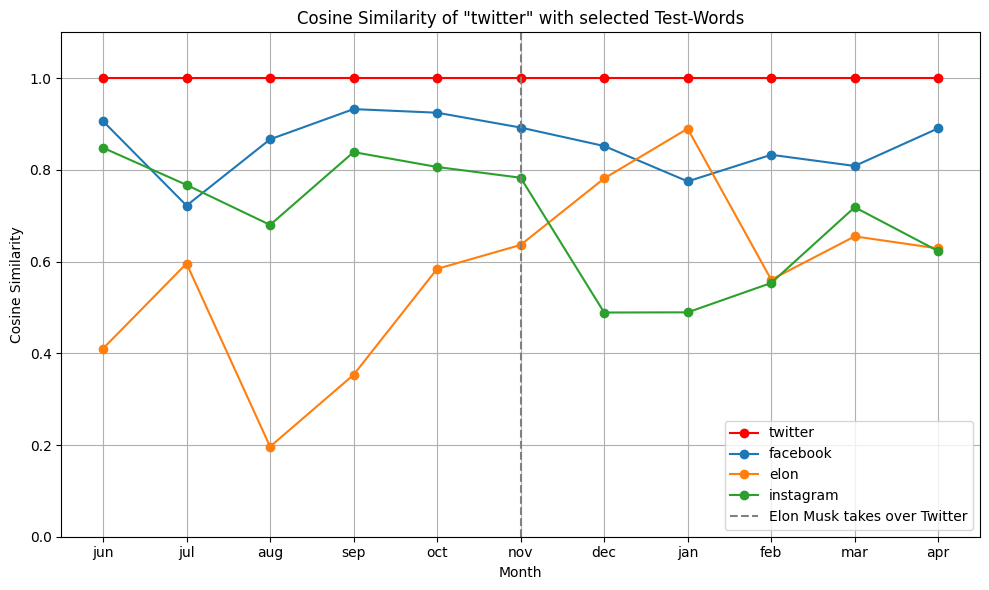

In [18]:
plot_cosine_similarity_cade(target_word_twitter, test_words_twitter, models_monthly, "nov", "Elon Musk takes over Twitter")

### TPPMI

In [19]:
test_words_twitter

['facebook', 'elon', 'instagram']

In [20]:
tppmi_twitter = tppmi_model.get_tppmi(test_words_twitter + [target_word_twitter], smooth=True);

All words are contained in the vocabulary
elon - not in vocab of timestep: 06
elon - not in vocab of timestep: 08
elon - not in vocab of timestep: 09


In [21]:
print(tppmi_twitter)

{'facebook':                    10            18         2      2022      2023  2024  \
facebook_06  0.000000  0.000000e+00  0.853245  0.305520  0.000000   0.0   
facebook_07  0.000000  0.000000e+00  0.000000  0.821610  0.000000   0.0   
facebook_08  0.000000  0.000000e+00  0.000000  1.862208  0.000000   0.0   
facebook_09  0.000000  1.720193e+00  0.000000  0.666737  0.000000   0.0   
facebook_10  0.000000  0.000000e+00  0.000000  0.954365  0.000000   0.0   
facebook_11  0.851593  1.570682e+00  0.000000  0.978494  0.000000   0.0   
facebook_12  0.613147  0.000000e+00  0.000000  1.238699  0.000000   0.0   
facebook_01  0.000000  0.000000e+00  0.190915  0.262916  0.105229   0.0   
facebook_02  0.000000  0.000000e+00  0.000000  0.521304  0.893128   0.0   
facebook_03  0.000000  0.000000e+00  0.068428  0.000000  1.993245   0.0   
facebook_04  0.000000  6.938894e-18  0.111186  1.180074  1.099540   0.0   

                   25        30   31       40  ...  wouldnt     write  \
facebook_06  

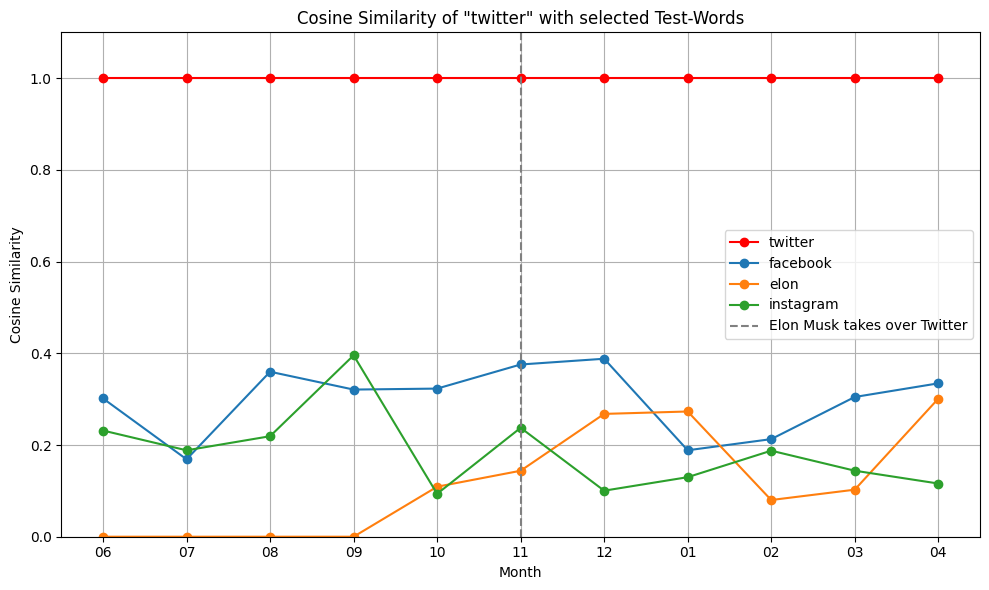

In [22]:
plot_cosine_similarity_tppmi("twitter", ["facebook", "elon", "instagram"], tppmi_model, event="11", event_name="Elon Musk takes over Twitter")

## Mass Shootings

### Overview

- **May:** Uvalde Robb Elementary School shooting (May 24, 2022)
- **November:** Colorado Springs nightclub shooting (November 19, 2022)
- **March:** Nashville school shooting (March 27, 2023)

In [23]:
target_word_shootings = "shooting"

In [24]:
# currently not used for plots
selected_months_shootings = ["jun", "jul", "aug", "sep", "oct", "nov"]
selected_models_monthly_shootings = {f"model_{month}": models_monthly[f"model_{month}"] for month in selected_months_shootings}

In [25]:
title_shootings = f"Evolution of the word {target_word_shootings} over time"
subtitle_shootings = f"Period: {' - '.join([month.capitalize() for month in selected_months_shootings])}"

In [26]:
print_most_similar_cade(models_monthly, target_word_shootings)

Word: shooting
Month: Jun
[('uvalde', 0.8860093355178833),
 ('texas', 0.7802619338035583),
 ('wsjcomarticlesdemoc', 0.7500583529472351)]
--------------------------------
Month: Jul
[('mass', 0.8167091012001038),
 ('robb', 0.8122766613960266),
 ('uvalde', 0.7859821319580078)]
--------------------------------
Month: Aug
[('massacre', 0.8483223915100098),
 ('mass', 0.8460655808448792),
 ('parkland', 0.8032575845718384)]
--------------------------------
Month: Sep
[('protests', 0.7818800210952759),
 ('murder', 0.7694730162620544),
 ('queens', 0.7689156532287598)]
--------------------------------
Month: Oct
[('robb', 0.8136457204818726),
 ('massacre', 0.7476783990859985),
 ('killed', 0.7434701323509216)]
--------------------------------
Month: Nov
[('parkland', 0.8928260803222656),
 ('teen', 0.8828899264335632),
 ('victim', 0.8613001704216003)]
--------------------------------
Month: Dec
[('coyotes', 0.7932825684547424),
 ('colorado', 0.7876253128051758),
 ('murder', 0.7869980931282043)]
--

### Temporarily changing embeddings

### Cosine similarities

In [27]:
target_word_shootings = "shooting"
test_words_shootings = ["uvalde", "colorado", "nashville"]

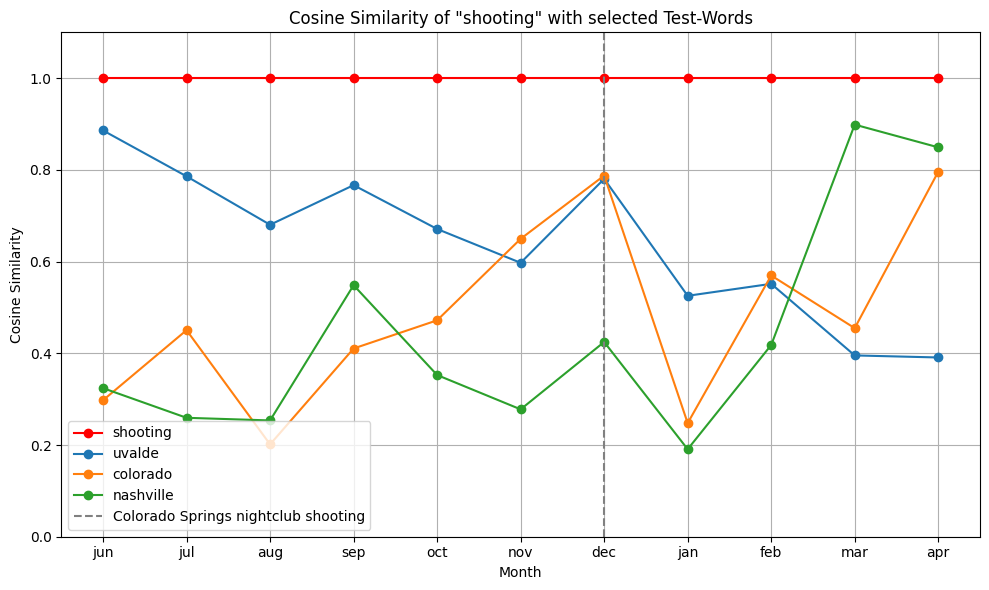

In [28]:
plot_cosine_similarity_cade(target_word_shootings, test_words_shootings, models_monthly, event="dec", event_name="Colorado Springs nightclub shooting")

### TPPMI

In [29]:
tppmi_shootings = tppmi_model.get_tppmi(test_words_shootings + [target_word_shootings], smooth=True)

All words are contained in the vocabulary
nashville - not in vocab of timestep: 12
nashville - not in vocab of timestep: 01


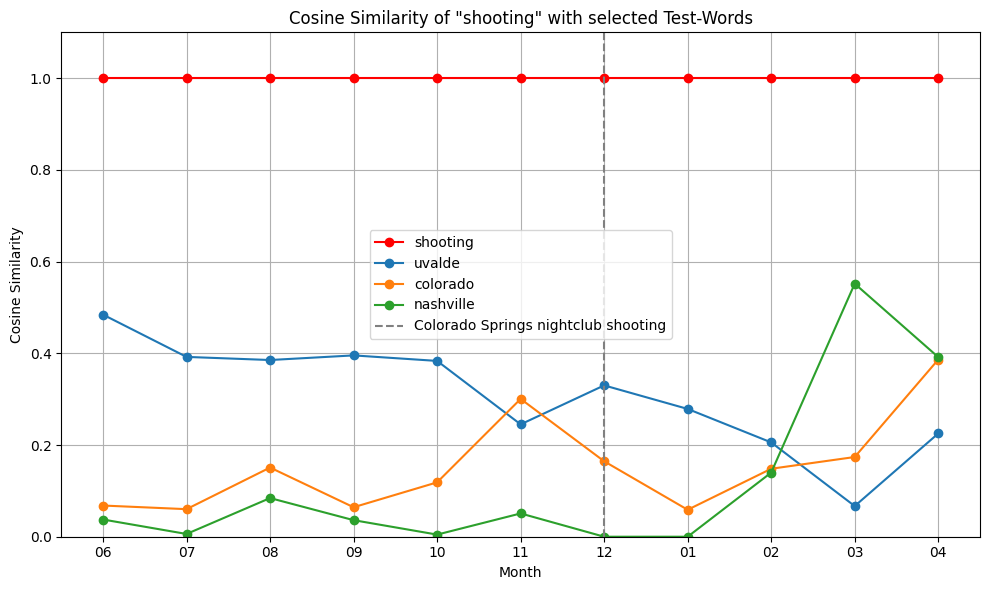

In [30]:
plot_cosine_similarity_tppmi(target_word_shootings, test_words_shootings, tppmi_model, event="12", event_name="Colorado Springs nightclub shooting")

## Disney vs DeSantis

On February 27, 2023, Florida Governor Ron DeSantis signed into law a measure that significantly altered the governance of the Reedy Creek Improvement District, a special taxing district that had long been under the control of The Walt Disney Company.

On April 26, 2023, Walt Disney Parks and Resorts sued DeSantis, Florida Department of Economic Opportunity acting secretary Meredith Ivey, and the Central Florida Tourism Oversight District board

In [31]:
target_word_disney = "disney"
test_words_disney = ["desantis", "florida", "improvement", "iger"]
title_disney = f"Evolution of the word {target_word_disney} over time"
event_name_disney = "DeSantis gains control over the district"

In [32]:
print_most_similar_cade(models_monthly, "iger", top_n=5)

Word: iger
Month: Jun
[('saka', 0.8935036659240723),
 ('heroic', 0.8894972801208496),
 ('boss', 0.8889265060424805),
 ('graying', 0.8888876438140869),
 ('itching', 0.8886404633522034)]
--------------------------------
Month: Jul
iger not in vocab
--------------------------------
Month: Aug
iger not in vocab
--------------------------------
Month: Sep
iger not in vocab
--------------------------------
Month: Oct
iger not in vocab
--------------------------------
Month: Nov
[('congresswoman', 0.9145722389221191),
 ('mchugh', 0.9126210808753967),
 ('threeterm', 0.9047982692718506),
 ('beshear', 0.8868262767791748),
 ('dupree', 0.8854271769523621)]
--------------------------------
Month: Dec
[('farleft', 0.9574562311172485),
 ('chapek', 0.9570642709732056),
 ('challenger', 0.9378390908241272),
 ('successor', 0.9311471581459045),
 ('thenceo', 0.929054319858551)]
--------------------------------
Month: Jan
[('chapek', 0.9497683644294739),
 ('1674162307although', 0.9376810789108276),
 ('rick'

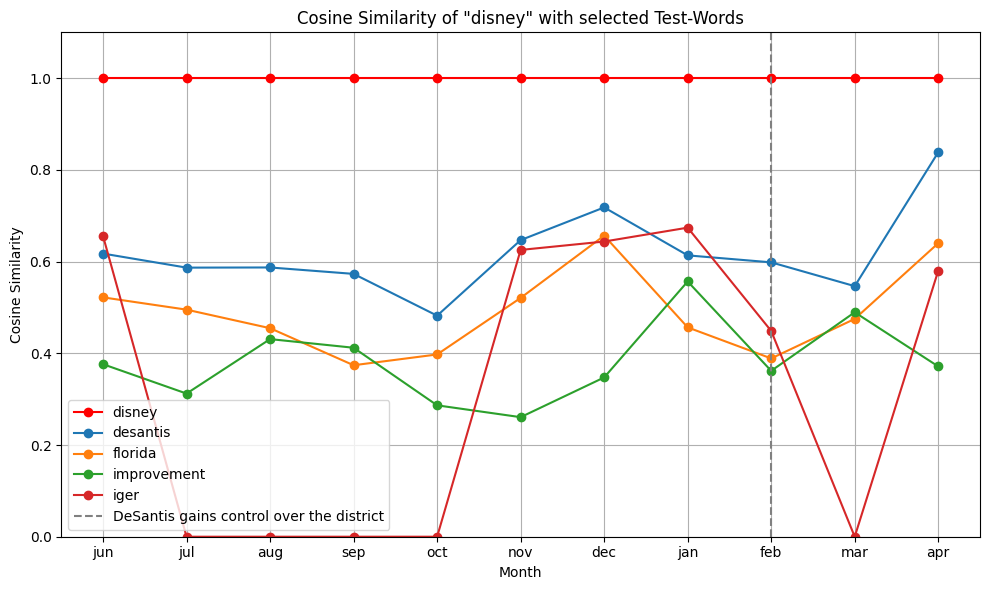

In [33]:
plot_cosine_similarity_cade(target_word_disney, test_words_disney, models_monthly, event_name=event_name_disney, event="feb")

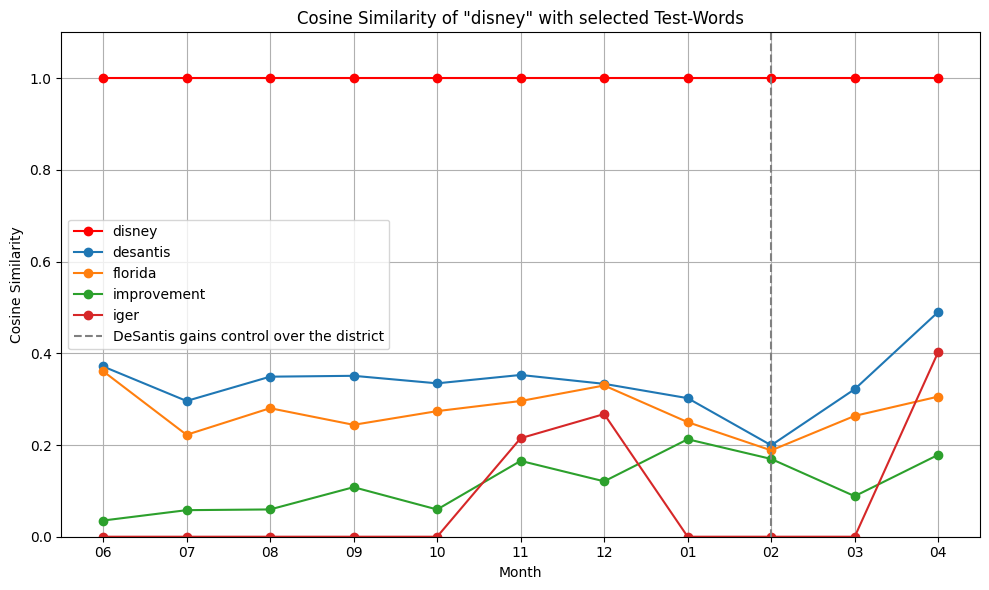

In [34]:
plot_cosine_similarity_tppmi(target_word_disney, test_words_disney, tppmi_model, event="02", event_name=event_name_disney)

# Experimental Section

## CRT

In [35]:
target_word = "woke"
test_words = ["forgiveness", "biden", "student"]

In [36]:
print_most_similar_cade(models_monthly, target_word, top_n=10)

Word: woke
Month: Jun
[('radical', 0.850493311882019),
 ('indoctrination', 0.8465880155563354),
 ('pushing', 0.8118022680282593),
 ('grooming', 0.8024293184280396),
 ('ideology', 0.7927407026290894),
 ('propaganda', 0.7834184169769287),
 ('queens', 0.7759100198745728),
 ('leftist', 0.7678560614585876),
 ('agenda', 0.759411633014679),
 ('lgbt', 0.7320221066474915)]
--------------------------------
Month: Jul
[('pushing', 0.7915792465209961),
 ('indoctrination', 0.7820501327514648),
 ('propaganda', 0.7611141204833984),
 ('leftist', 0.7449070811271667),
 ('marxist', 0.732366144657135),
 ('censor', 0.707105815410614),
 ('agenda', 0.6961795687675476),
 ('radical', 0.6950430274009705),
 ('restricting', 0.6909219026565552),
 ('whitesupremacy', 0.689655065536499)]
--------------------------------
Month: Aug
[('indoctrination', 0.8580688238143921),
 ('ideology', 0.834745466709137),
 ('pushing', 0.8277775645256042),
 ('radical', 0.8249157667160034),
 ('agenda', 0.773681104183197),
 ('leftist', 0

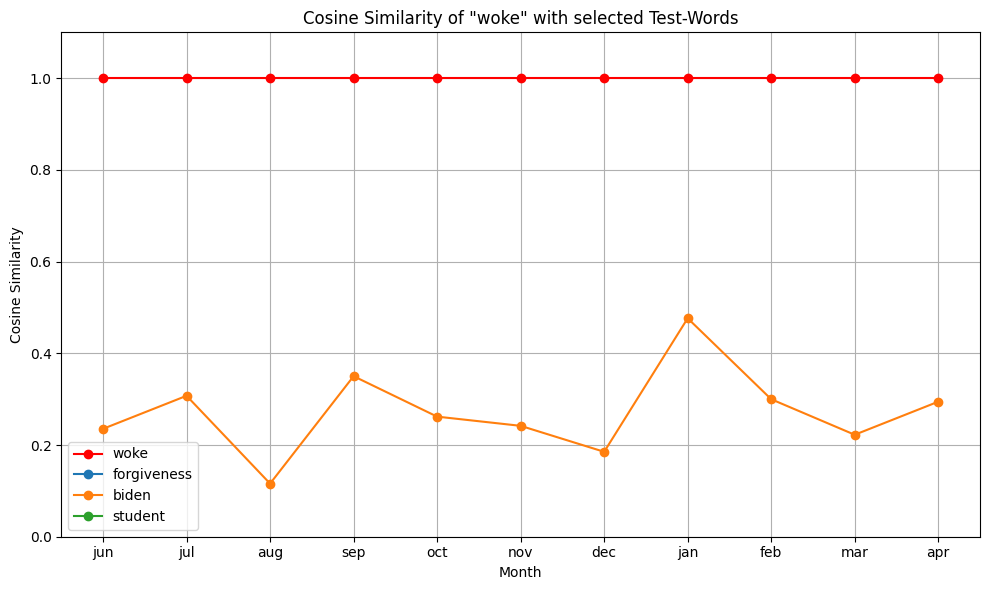

In [37]:
plot_cosine_similarity_cade(target_word, test_words, models_monthly)